<a href="https://colab.research.google.com/github/vikamayr/Computer-Vision/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import random
import glob
from PIL import Image
import shutil

In [ ]:
# Download and unzip dataset for preprocessing
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip

# Create folders for training and test datasets 
!mkdir dataset
!mkdir dataset_test

In [3]:
# function that resizes image into 600x600 and convert it into grayscale
def image_preprocess(img):
  img2 = img.resize((600,600)).convert('L')
  return img2

# loop and preprocess downloaded images
for filename in glob.glob('val2017/*.jpg'):
  img_name = filename.split('/')[1]
  img=Image.open(filename)
  preprocessed_img = image_preprocess(img)
  preprocessed_img.save('dataset/{}'.format(img_name))


# extract 100 images from dataset to be used in testing 
counter = 0
for filename in glob.glob('dataset/*.jpg'):
  shutil.move("{}".format(filename), "dataset_test/")
  counter +=1
  if counter == 100:
    break

In [17]:
# Create dataset of 600x600
image_size = (600,600)

train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset',
    labels='inferred',
    label_mode=None,
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    subset='training',
    validation_split=0.898, # to get dataset of 600 images
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

# Create dataset of 600x600 
val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset',
    labels='inferred',
    label_mode=None,
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    subset='validation',
    validation_split=0.0205,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


# Create dataset of 600x600 
test_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset_test',
    labels='inferred',
    label_mode=None,
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=image_size,
    shuffle=True,
    seed=42,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 4900 files belonging to 1 classes.
Using 500 files for training.
Found 4900 files belonging to 1 classes.
Using 100 files for validation.
Found 100 files belonging to 1 classes.


In [28]:
# Unbatch datasets
train_x = np.concatenate([x for x in train_ds], axis=0)
val_x = np.concatenate([x for x in val_ds], axis=0)
test_x = np.concatenate([x for x in test_ds], axis=0)

In [29]:
# Check dataset shape
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(500, 600, 600, 1)
(100, 600, 600, 1)
(100, 600, 600, 1)


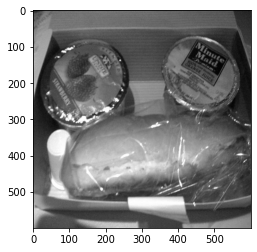

In [30]:
# view random image from training dataset
plt.imshow(train_x[random.randint(0, 499)].squeeze())
plt.gray()

In [34]:
# Check the min and max value of pixels
print(train_x.max(), train_x.min(), train_x.dtype)
print(val_x.max(), val_x.min())
print(test_x.max(), test_x.min())

255.0 0.0 float32
255.0 0.0
255.0 0.0


In [35]:
# scale data between 0-1 for normalization
x_train = train_x.astype('float32') / 255.
x_val = val_x.astype('float32') / 255.
x_test = test_x.astype('float32') / 255.

In [36]:
# recheck the min and max value of pixels
print(x_train.max(), x_train.min())
print(x_val.max(), x_val.min())
print(x_test.max(), x_test.min())

1.0 0.0
1.0 0.0
1.0 0.0


In [26]:
def build_autoencoder(img_shape):
    # ENCODER
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
    encoder.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))
    encoder.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    encoder.add(tf.keras.layers.MaxPooling2D((2, 2), padding='same'))

    # DECODER
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
    decoder.add(tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
    decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
    decoder.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
    decoder.add(tf.keras.layers.UpSampling2D((2, 2)))
    decoder.add(tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return encoder, decoder

img_shape = (600,600,1)

encoder, decoder = build_autoencoder(img_shape)
inp = tf.keras.layers.Input(img_shape)
code=encoder(inp)
reconstruction=decoder(code)

autoencoder = tf.keras.models.Model(inp, reconstruction)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.MSE)

print(encoder.summary())
print(decoder.summary())
print(autoencoder.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 600, 600, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 300, 300, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 300, 300, 8)       1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 150, 150, 8)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 150, 150, 8)       584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 75, 8)        0

In [27]:
# Train autoencoder
history = autoencoder.fit(x=x_train, y=x_train, batch_size=16, epochs=5, validation_data=[x_val, x_val])

Epoch 1/5
32/32 [==============================] - 277s 9s/step - loss: 0.0672 - val_loss: 0.0303
Epoch 2/5
32/32 [==============================] - 268s 8s/step - loss: 0.0160 - val_loss: 0.0108
Epoch 3/5
32/32 [==============================] - 268s 8s/step - loss: 0.0105 - val_loss: 0.0092
Epoch 4/5
32/32 [==============================] - 295s 9s/step - loss: 0.0090 - val_loss: 0.0083
Epoch 5/5
32/32 [==============================] - 282s 9s/step - loss: 0.0084 - val_loss: 0.0087


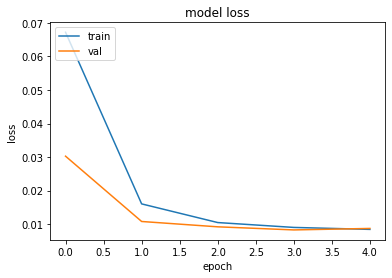

In [39]:
# plot training results
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [40]:
autoencoder.evaluate(x_test)

4/4 [==============================] - 0s 35ms/step - loss: 0.0000e+00


0.0

4/4 [==============================] - 22s 3s/step


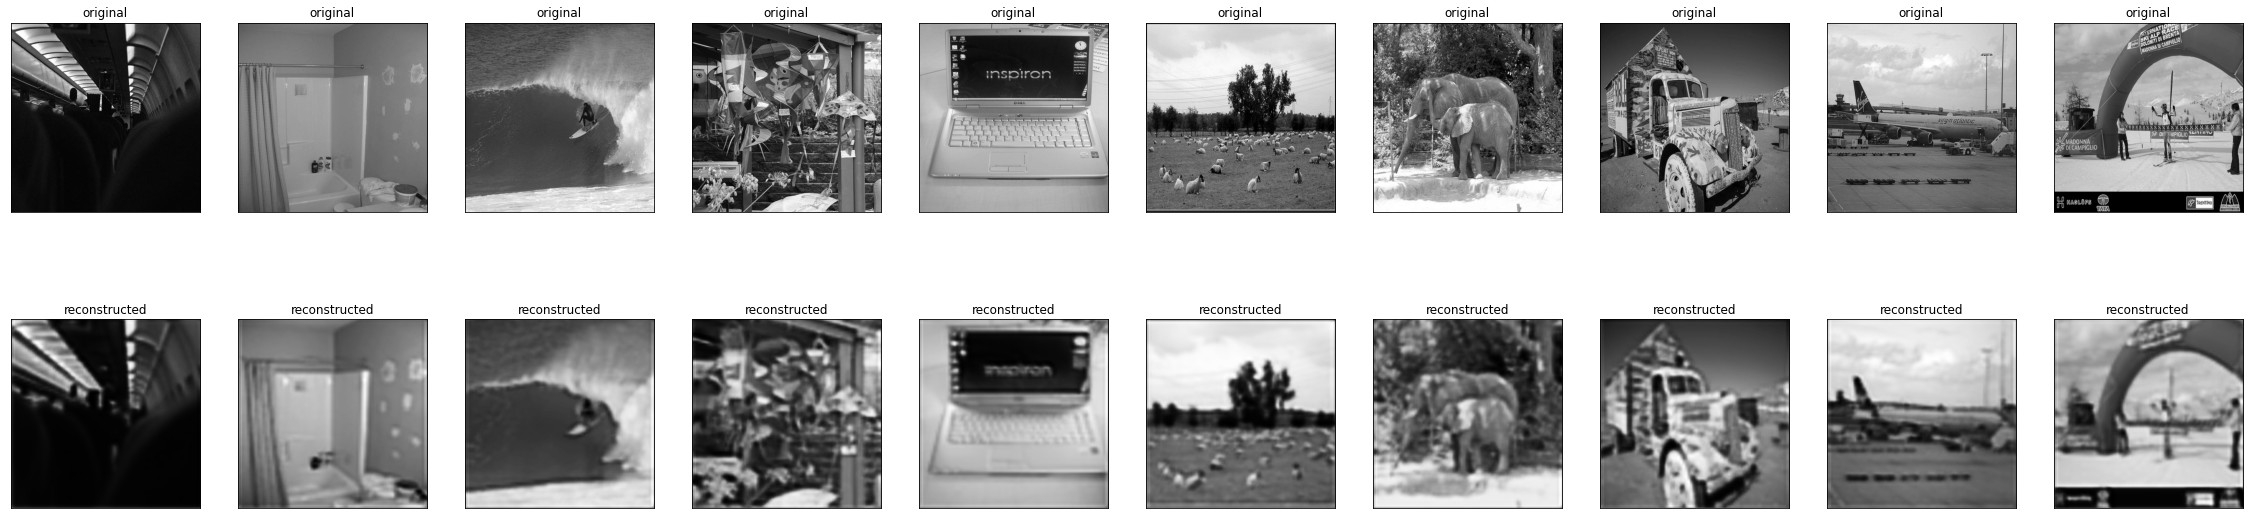

In [41]:
# predict with test_set and visualize images
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(40, 10))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].squeeze())
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].squeeze())
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

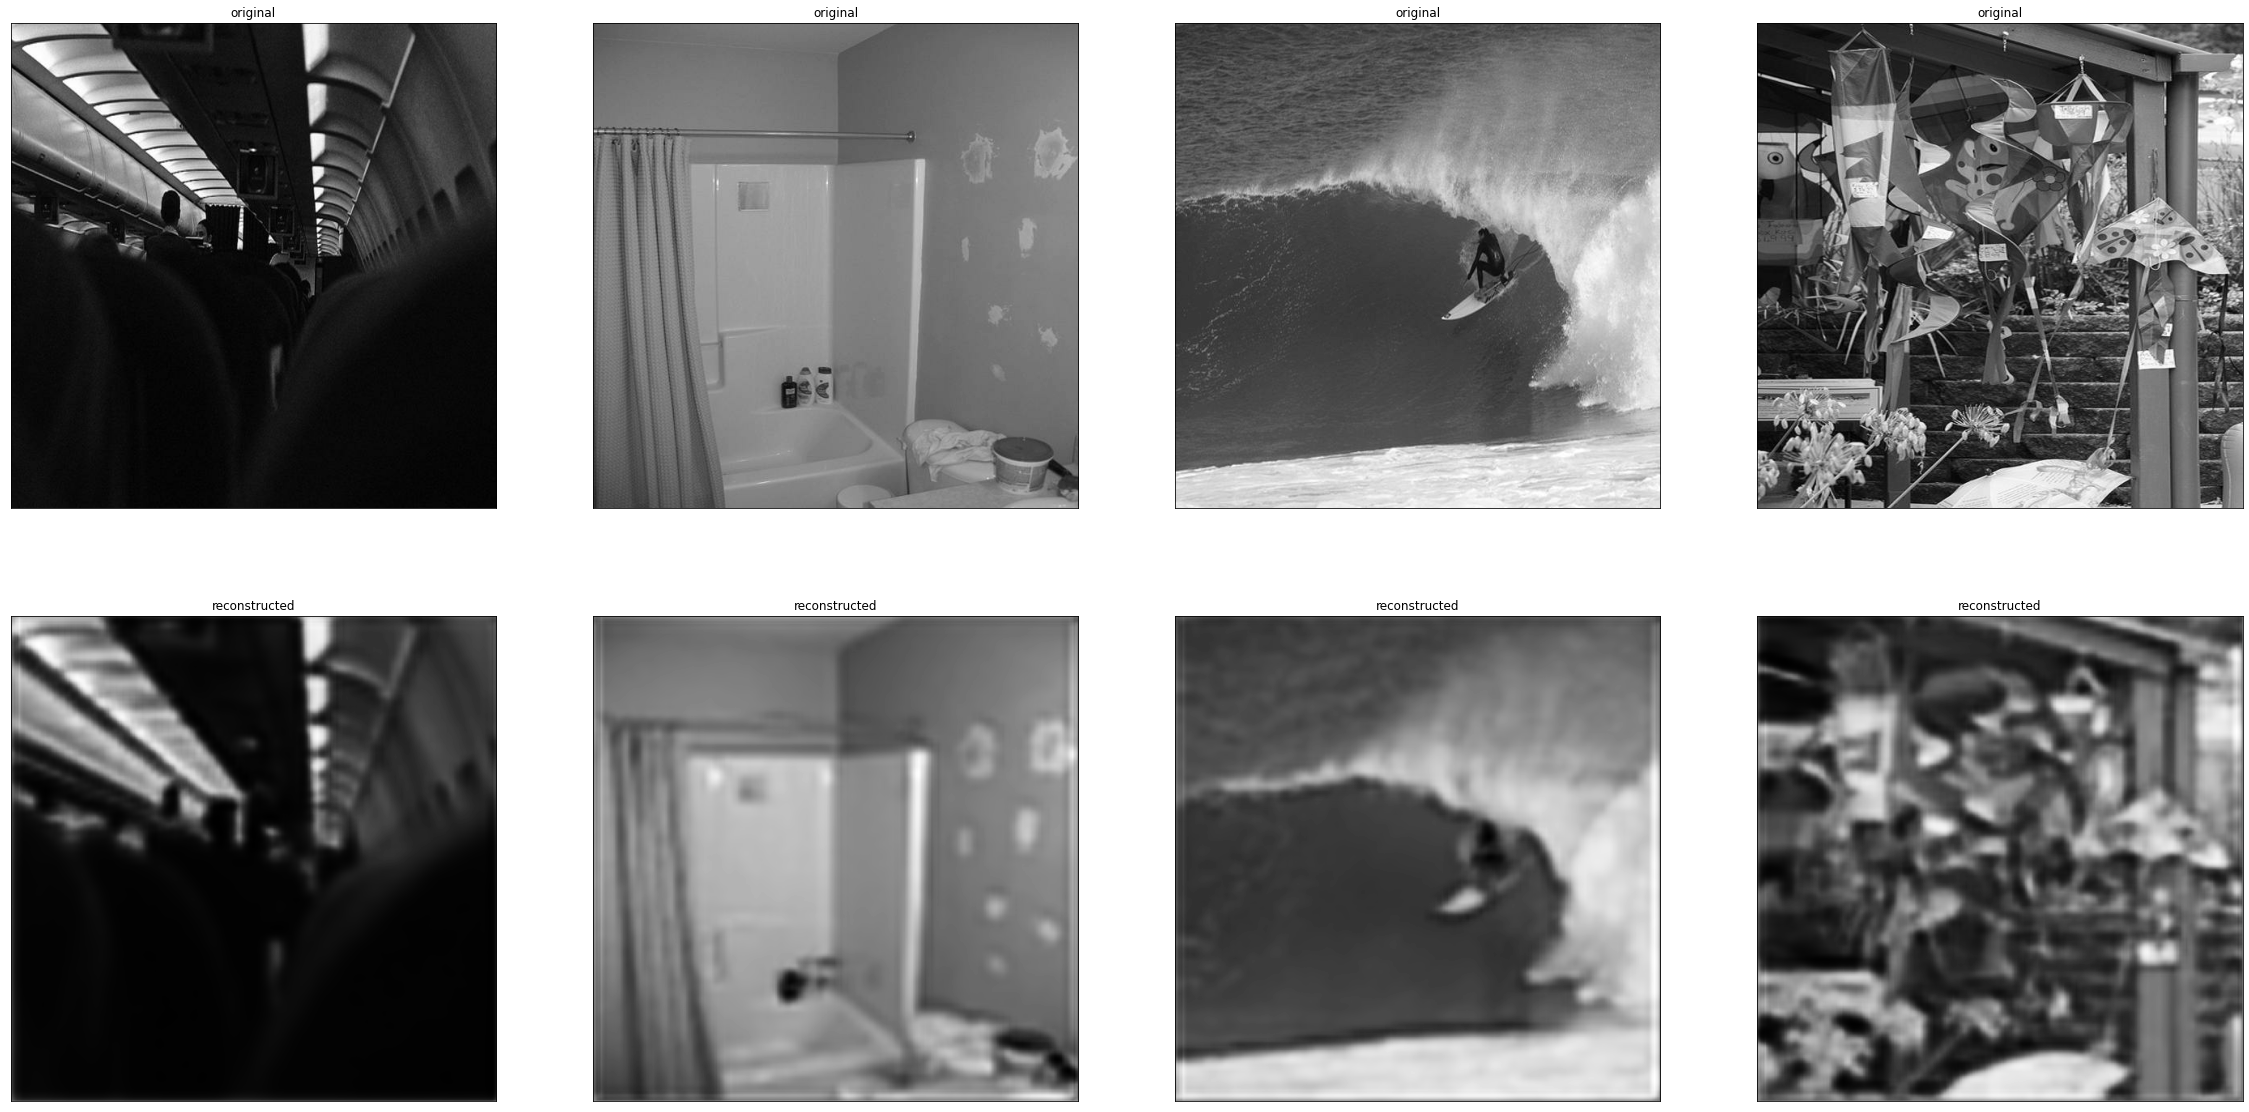

In [43]:
# Larger visualization
n = 4
plt.figure(figsize=(40, 20))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].squeeze())
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i].squeeze())
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()